https://es.wikipedia.org/wiki/Frecuencia_de_muestreo

https://www.youtube.com/watch?v=9GxcNyGQsuk

https://ernestocrespo13.wordpress.com/2013/02/19/teorema-de-muestreo-explicado-con-numpy/

https://pybonacci.org/2012/09/29/transformada-de-fourier-discreta-en-python-con-scipy/

# Determinación de los parámetros de adquisición de una señal fisiológica

La medida de una magnitud física suele llevarse a cabo en la siguiente secuencia: transducción, muestreo y cuantización.

La transducción consiste en la conversión de la magnitud física (posición, ángulo, velocidad, presión, tensión mecánica, temperatura, etc.) en una señal de voltaje o intensidad, esto es, una señal eléctrica. El muestreo consiste en pasar de esa señal eléctrica que varía contínuamente en el tiempo, a una señal en paquetes de tiempo (valores promedios, por ejemplo), esto es, discreta en el tiempo. La cuantización consiste en pasar de estos valores de señal que pueden tomar valores arbitrariamente próximos entre ellos, a valores agrupados por tramos, esto es, que pueden tomar valores discretos o digitales.

Así, el resultado de una medida de una magnitud física continua o analógica se ha convertido en un listado digital de números enteros o, cuando menos, (a través de coeficientes multiplicativos de calibración) discretos, cada uno correspondiente a un tiempo de muestreo.

El objetivo de este ejercicio es que usted determine, a partir del análisis del archivo de datos proporcionado, procedente de una medida de presión intracardiaca con una tarjeta digitalizadora Keithley, cuáles fueron los settings de dicha tarjeta usados para la digitalización.

En particular, deberá usted determinar:

- frecuencia de muestreo.
- frecuencia de Nyquist de la señal.
- bits de cuantificación.
- ganancia de la digitalización (factor multiplicador de calibración).
- polaridad de la medida (es decir, si la medida original era monopolar, esto es, sólo comprendía valores positivos de voltaje o si, por el contrario, era bipolar, esto es, comprendía valores tanto positivos como negativos de la señal eléctrica).
    
**DATOS**

Archivo de texto con dos columnas `1800031_PSentronMP.dat`; tiempo en segundos y presión calibrada en mmHg.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    "1_d1800031_PSentronMP.dat", 
    names=["seconds", "mmHg"]
)

df.head()

,seconds,mmHg
0,0.001,95.007489
1,0.002,95.007489
2,0.003,95.128993
3,0.004,95.250498
4,0.005,95.250498


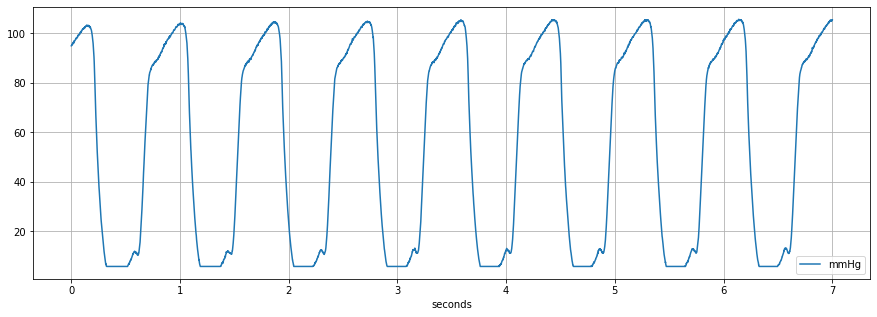

In [2]:
df.plot(
    x="seconds", 
    y="mmHg", 
    kind="line", 
    figsize=(15, 5), 
    grid=True
)
plt.show()

Con el objetivo de estimar el período de nuestra gráfica veamos los puntos para los cuales la presión coincide con nuestra primera muesta de datos (no es necesaria la primera muestra ya que se trata de una onda periódica y supondremos que habrá repetición debido a la gran cantidad de datos).

In [3]:
df.loc[df["mmHg"] == df.loc[0, "mmHg"], ["seconds", "mmHg"]]
# df.loc[df["mmHg"] == df.loc[0, "mmHg"], "seconds"].index

,seconds,mmHg
0,0.001,95.007489
1,0.002,95.007489
854,0.855,95.007489
1706,1.707,95.007489
1707,1.708,95.007489
1708,1.709,95.007489
2782,2.783,95.007489
3416,3.417,95.007489
4270,4.271,95.007489
5121,5.122,95.007489


El período será la diferencia de tiempos consecutivos en nuestro anterior dataframe. Por ejemplo `(0.855 - 0.002)`. Con estos datos podemos estimar la **frecuencia de Nyquist**.

In [4]:
dn = df.loc[df["mmHg"] == df.loc[0, "mmHg"], "seconds"]
fn = []
T = []

for i in range(0, len(dn)-1):
    T.append(dn[dn.index[i+1]] - dn[dn.index[i]])
    if T[i] > 0.5: # eliminar valores extraños
        nyquist = 2 * 1/(T[i])
        fn.append(nyquist)
        print("Frecuencia de Nyquist estimada: ", nyquist)
print(" ")        
print("Frecuencia de Nyquist media: ", sum(fn)/len(fn))

Frecuencia de Nyquist estimada:  2.3446658851113718
Frecuencia de Nyquist estimada:  2.3474178403755865
Frecuencia de Nyquist estimada:  1.8621973929236502
Frecuencia de Nyquist estimada:  3.154574132492114
Frecuencia de Nyquist estimada:  2.34192037470726
Frecuencia de Nyquist estimada:  2.3501762632197414
Frecuencia de Nyquist estimada:  2.3391812865497066
 
Frecuencia de Nyquist media:  2.391447596482776


**Para la pendiente**

Ordenamos valores.

In [5]:
df_rl = df.sort_values(by="mmHg", ascending=True)
df_rl.head()

,seconds,mmHg
2987,2.988,5.823069
2194,2.195,5.823069
2195,2.196,5.823069
2196,2.197,5.823069
2197,2.198,5.823069


Eliminamos repetidos y hacemos regresión lineal.

Niveles de cuantificación:  766
Coefficients:  [0.13377109]
Independent term:  4.506166771031793
Mean Squared Error (MSE): 0.45
R2: 1.00


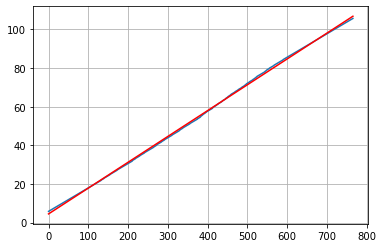

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

y = df_rl["mmHg"].unique()
x = np.array(range(0, len(y)))

print("Niveles de cuantificación: ", len(y))

# Creamos el objeto para regresion lineal
regr = linear_model.LinearRegression()
# Entrenamos nuestro modelo
regr.fit(x.reshape(-1, 1), y)
# Hacemos las predicciones
y_pred = regr.predict(x.reshape(-1, 1))
 
# Tangente
print("Coefficients: ", regr.coef_)
# Término independiente
print("Independent term: ", regr.intercept_)
# MSE
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(y, y_pred))
# R2, tiende a 1.0
print("R2: %.2f" % r2_score(y, y_pred))

plt.grid(True)
plt.plot(x, y)
plt.plot(x, y_pred, color="red")
plt.show()

In [7]:
bits = 2 ** np.array(range(0, 24))

# Dos métodos, debería dar el mismo resultado
print("Bits de cuatificación: ", np.log2([c for c in bits if c > len(y)][0]))
print("Bits de cuatificación: ", np.ceil(np.log2(len(y))))

Bits de cuatificación:  10.0
Bits de cuatificación:  10.0
